# Table of Contents 
1. [Project Overview](#overview)
2. [Get The Data](#data)
3. [Data Exploration](#exploration)
4. [Data Preparation](#prep)
5. [Model Selection & Evaluation](#model_selection)
6. [Final Tuning The Model](#final_model)
7. [Presenting Our Solution](#conclusion)

## Project Overview <a name="overview"></a>


### Business Problem

This project attempts to define the relationship between student performance variables and student term grades using predictive and descriptive analytics techniques.

The project findings will enable school administrations to proactively identify students who may lack academic support due to their "learning environments" and ensure that additional learning resources are made apparent to them. Reducing the number of struggling students in our school systems will serve to attract prospective students and secure further funding as student success and enrollment increase.

Our dataset represents the cumulation of data collection efforts from two separate Portuguese schools.

### Frame The Problem


We aim to deliver a model that will predict each student's final term grades. This can be done in a variety of ways using a few different machine-learning techniques.

First, we have to decide whether our problem requires a supervised or unsupervised model. 

`Supervised models` try to predict a certain value that is chosen before the model creation process. They then use these values known as `target values` to judge their effectiveness and accuracy. For example, a model might try to predict "rental price" from a given set of values (sqft, # of bedrooms, bathrooms, etc.). The rental price in this example would be a target value.

On the other hand, `unsupervised models` have no target value. Their only purpose is to recognize patterns and separate data into similar segments. Since we have a value to predict, this project will only use supervised learning with the target value being final student grades.

### Machine Learning Task

Our supervised model can create final prediction grades in one of two ways:

> <u>Classification</u>: Classification models make predictions in non-continuous categoricalintervals. For predicting student grades we would use the letter grade below as the target value.

> <u>Regression</u>: Regression models predict in continuous intervals. A regression model in this instance would utilize the Portugese Number Grading scale below from 0-20.
<br>

Our student grades model will leverage classification techniques, meaning final predictions will be in the form of letter grades. Our original dataset represents student term grades on a continuous scale. This will require us to group grade values into their corresponding pass-or-fail grade so we can leverage a binary target value for classification.

Using classification will allow us to tune the model more effectively to capture a higher percentage of struggling students, something that would not be possible with regression techniques.

|Number Grade|Letter Grade|Pass/Fail|
|---|---|---|
|18.00-20.00|A+| Pass |
|16.00-17.99|A| Pass |
|14.00-15.99|B| Pass |
|10.00-13.99|C| Pass |
|0.00-9.99|F| Fail |

### Metrics

Our model will be judged based on how well it can recognize students who are struggling. In other words, what percent of struggling students it can correctly classify as such. This class of prediction is commonly known as a `true positive`; the model predicted it to be of the target class (in this case a student that needs assistance) when it is actually a member of the target class.

The risk of ignoring a needy student is much higher than that of incorrectly making extra resources available to a student who might not necessarily need them. Our predictive model will be more effective as it recognizes more struggling students. 

This ability to capture true positives is known as `Recall` or `Senstivity` and it is calculated as <i>the number of correctly classified members of the target class divided by the total number of instances actually in the target class</i>. In our case, recall would be the number of needy students identified as such divided by the total number of needy students in our student population.


<div>
    <center>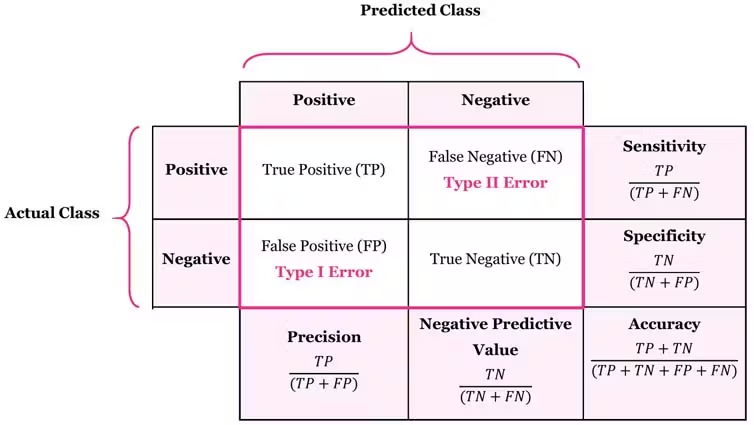 </center>
</div>


Maximizing this Recall value does come with a tradeoff. The higher the identification rate of needy students the more likely the model will incorrectly label a high-performing student as a needy student. This is known as the `Precision-Recall tradeoff`. We need to make sure that we consider this balance between accuracy and recall while training and also impliment downstream solutions to make sure that misclassified students are identified and appropriate action is taken while still allotting resources to all students that need them.

### Library Imports

In [131]:
# Initial library and function imports that will be used throughout the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

## Get The Data <a name="data"></a>


### Import The Data

In [132]:
# Import the dataset from within the project folder. Create numeric version we will use for correlation matrixes.
final_data = pd.read_csv("student-mat.csv")

# Rename some columns to make them more intuituve
final_data = final_data.rename(columns = {"absences_G1":"absences_term1", "absences_G2":"absences_term2", "absences_G3":"absences_final",
                  "G1": "Term1_Grade", "G2": "Term2_Grade", "G3": "Final_Grade"})

final_data_numeric = final_data.copy()

Like previously stated we will represent final term grades as pass or fail and not in their original continuous form so that we can tune model preferences. Let's take a look at the datatypes of the final three columns after binning them. They are now categories and can be used for classification.

We will create a target value with scale of 1 and 0 in the `final_data_numeric` data frame. This data frame will be used to test correlation between numeric columns and the target class

In [133]:
#Bin the term columns into Fail or Pass to make them categorical.
final_data["Final_Grade"] = pd.cut(final_data["Final_Grade"], bins = [-0.01, 9.99, 20], labels = ["Fail", "Pass"])

### Check The Size and Type of Data

Our data has 395 rows and 35 different features. We have a collection of cateogrical and numerical data. Meaning that some of our data is represented as numbers and some are categories.

In [134]:
# Data is 395 rows long and has 35 different features. The dataset has a total of 13825 cells.
print(final_data.shape)
print(final_data.size)

(395, 35)
13825


In [135]:
print(final_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   school          395 non-null    object  
 1   sex             395 non-null    object  
 2   age             383 non-null    float64 
 3   address         395 non-null    object  
 4   famsize         395 non-null    object  
 5   Pstatus         395 non-null    object  
 6   Medu            395 non-null    int64   
 7   Fedu            395 non-null    int64   
 8   Mjob            395 non-null    object  
 9   Fjob            395 non-null    object  
 10  reason          395 non-null    object  
 11  guardian        395 non-null    object  
 12  traveltime      395 non-null    int64   
 13  studytime       395 non-null    int64   
 14  failures        395 non-null    int64   
 15  schoolsup       395 non-null    object  
 16  famsup          395 non-null    object  
 17  paid            

    
### Data Features 

1. `school`: student's school ("GP" - Gabriel Pereira or "MS" - Mousinho da Silveira) (<i>object</i>)
2. `sex`: student's sex ("F": female or "M": male) (<i>object</i>)
3. `age` : student's age (from 15 to 22) (<i>float64</i>)
4. `address`: student's home address type ("U": urban or "R": rural) (<i>object</i>)
5. `famsize`: family size ("LE3" - less or equal to 3 or "GT3" - greater than 3) (<i>object</i>)
6. `Pstatus`: parent's cohabitation status ("T" - living together or "A" - apart) (<i>object</i>)
7. `Medu`: mother's education (0 - none, 1 - primary education (4th grade), 2 – 5th to 9th
grade, 3 – secondary education or 4 – higher education) (<i>int64</i>)
8. `Fedu`: father's education (0 - none, 1 - primary education (4th grade), 2 – 5th to 9th
grade, 3 – secondary education or 4 – higher education) (<i>int64</i>)
9. `Mjob`: mother's job (<i>object</i>)
10. `Fjob`: father's job (<i>object</i>)
11. `reason`: reason to choose this school (close to "home", school "reputation", "course"
preference or "other") (<i>object</i>)
12. `guardian`: student's guardian (<i>object</i>)
13. `traveltime`: home to school travel time (1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1
hour, or 4 - >1 hour) (<i>int64</i>)
14. `studytime`: weekly study time (1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10
hours) (<i>int64</i>)
15. `failures`: number of past class failures (n if 1<=n<3, else 4) (<i>int64</i>)
16. `schoolsup`: extra educational support (Y or N) (<i>object</i>)
17. `famsup`: family educational support (Y or N) (<i>object</i>)
18. `paid`: extra paid classes within the course subject (Math or Portuguese) (Y or N) (<i>object</i>)
19. `activities`: extra-curricular activities (Y or N) (<i>object</i>)
20. `nursery`: attended nursery school (Y or N) (<i>object</i>)
21. `higher`: wants to take higher education (Y or N) (<i>object</i>)
22. `internet`: Internet access at home (Y or N) (<i>object</i>)
23. `romantic`: with a romantic relationship (Y or N) (<i>object</i>)
24. `famrel`: quality of family relationships (from 1 - very bad to 5 - excellent) (<i>int64</i>)
25. `freetime`: free time after school (from 1 - very low to 5 - very high) (<i>int64</i>)
26. `goout`: going out with friends (from 1 - very low to 5 - very high) (<i>int64</i>)
27. `Dalc`: workday alcohol consumption (from 1 - very low to 5 - very high) (<i>int64</i>)
28. `Walc`: weekend alcohol consumption (from 1 - very low to 5 - very high) (<i>int64</i>)
29. `health`: current health status (from 1 - very bad to 5 - very good) (<i>int64</i>)
30. `absences_term1`: number of school absences for G1 term (<i>float64</i>)
31. `absences_term2`: number of school absences for G2 term (<i>float64</i>)
32. `absences_final`: number of school absences for G3 term (<i>float64</i>)
33. `Term1_Grade`: first term grade (Pass or Fail) (<i>category</i>)
34. `Term2_Grade`: second term grade (Pass or Fail) (<i>category</i>)
35. `Final_Grade`: final grade (Pass or Fail) ← <b>target value</b> (<i>category</i>)

### Identify Target Value

The `Final_Grade` column represents the student's grades in the final term of the school year. This column will be our target variable, what we are trying to predict.

## Data Exploration<a name="exploration"></a>

### Studying the Features In our Dataset

It is important to understand the distribution of our variables and how they relate to eachother so that we can make necessary adjustments prior to feeding that data through our model.

The bar plot below shows where our data originates from. About 85% comes from the Gabriel Periera School and 15% from the Mousinho da Silveira school. Knowing where our data comes from helps to understand what population our data might represent. In this case our project would be most applicable the GP school since thata makes most of our population. If needed we could create seperate predictive models for each school to be more accurate.

### Visualizing Our Data

These data visualization will give an idea of how our data is distributed and proportioned in our dataset

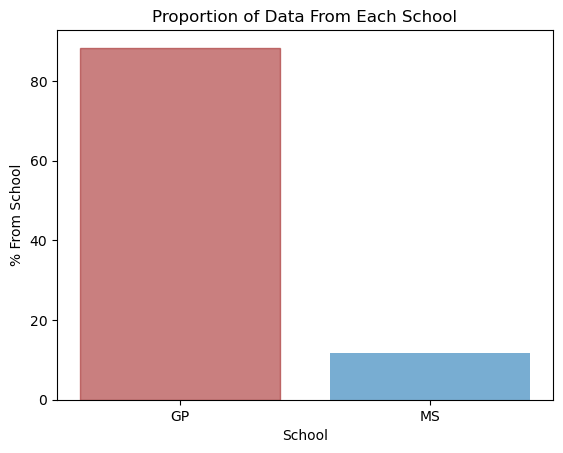

In [136]:
# Create a bar plot to see which school these data points come from
school = final_data["school"].value_counts(normalize=True)
x = plt.bar(school.index, height = school.values * 100.0, label = school.index, alpha = 0.6)
x[0].set_color("brown")
plt.title("Proportion of Data From Each School")
plt.xlabel("School")
plt.ylabel("% From School")
plt.show()

We can make a pie chart to see the distribution of our target variable `G3` after binning. from this chart we can see that our target class makes up 33% of the data. If the proportion of the target class was much smaller, say 5-10% we may have had to oversample it when training our model. However, 33% is a large enough proportion to sample the data as it is given to us.

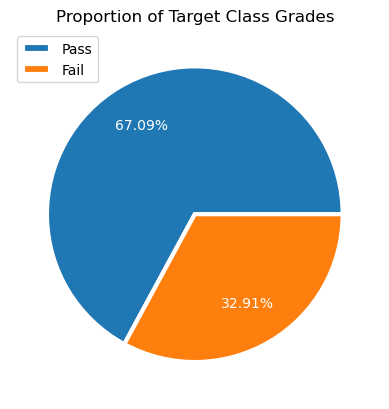

In [137]:
# Create a pie chart that shows the distribution of the target class.
target_prop = final_data["Final_Grade"].value_counts(normalize = True)
plt.pie(target_prop, autopct='%1.2f%%', pctdistance=0.7, labeldistance=0.7,  textprops={'color':"w"} ,wedgeprops={
    "edgecolor": "white", "linewidth": 3})
plt.title("Proportion of Target Class Grades")
plt.legend(target_prop.index, loc='upper left')
plt.show()

### Correlations Between Attributes

From the correlation matrix below we can see that other than the `absence` and `term grade` columns, none of the variables have correlations with each other above 0.7. A high correlation between features means that there is redundancy in our dataset. Dropping or combining the highly correlated columns simplifies our dataset while retaining the information.

Because of the high correlation within the absence columns we will be combining them into one `absence_total` column later on. We will also create two datasets; one that contains the `Term1_Grade` and `Term2_Grade` columns and one without them given their high correlation with each other.

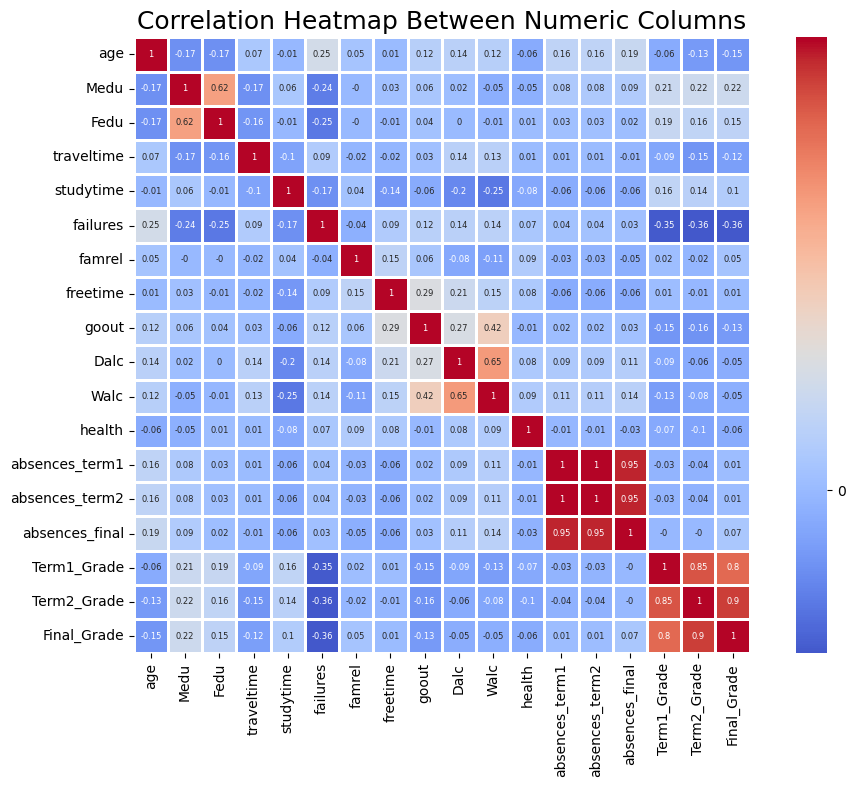

In [138]:
#Correlation matrixes help us see which features we can leave out of the dataset.

plt.figure(figsize=(12, 8))

#Choose only numerical columns

num_attributes = list(final_data_numeric.select_dtypes(include=['number']).columns)
cat_col = list(final_data_numeric.select_dtypes(exclude=['number']).columns)
num_df = final_data_numeric[num_attributes].copy()

#Create correlation matrix and create seaborn plot
corr_df = num_df.corr(numeric_only=True)
annot_arr = np.round(corr_df.values, 2)
sns.heatmap(corr_df, linewidths=2, linecolor="white", cmap="coolwarm", annot=annot_arr,
            annot_kws={"size": 6}, center = 0.3, square = "True", cbar_kws={"ticks":np.arange(0,1)})
plt.title("Correlation Heatmap Between Numeric Columns", fontsize = 18)
plt.show()

We have just seen the way that numeric columns correlate with the target variable. We need a different way to see if the target value is dependent on any of the features or if they are independent of each other. For this, we can make use of the chi-squared independence test. This test runs with the null hypothesis that the values are independent. If our chi-square test returns a p-value of below our threshold of 0.5 then we know that the target value and that featured are significantly related.

This chi-square analysis will help use reduce the dimensions of our training data to extract the features that are meaningful in deciding our target variable.

Let us visualize these tests below with a bar chart. The value of each bar is a result of a seperate chi-square independence test between each feature and the target variable `Final_Grade`.

In [139]:
# Create a list of columns that are categorical without the transformed target value. final_data has a Pass/Fail target
# value.
cat_list = list(final_data.describe(include = ["object", "category"]).columns)[:-1]

chi_list = []

# Run a Chi-Square independence test for each categorical column in the dataset.
for col in cat_list:
    cross = pd.crosstab(final_data[col], final_data["Final_Grade"], margins=True, margins_name="subtotal")
    
    #Get the p-value for each chi test and append to the list
    chi_list.append(chi2_contingency(cross)[1] - 0.01)

#Organize our cumulative chi2 test results into a dataframe.
chi2_df = pd.DataFrame(chi_list, index=cat_list, columns = ["chi_values"]).reset_index()

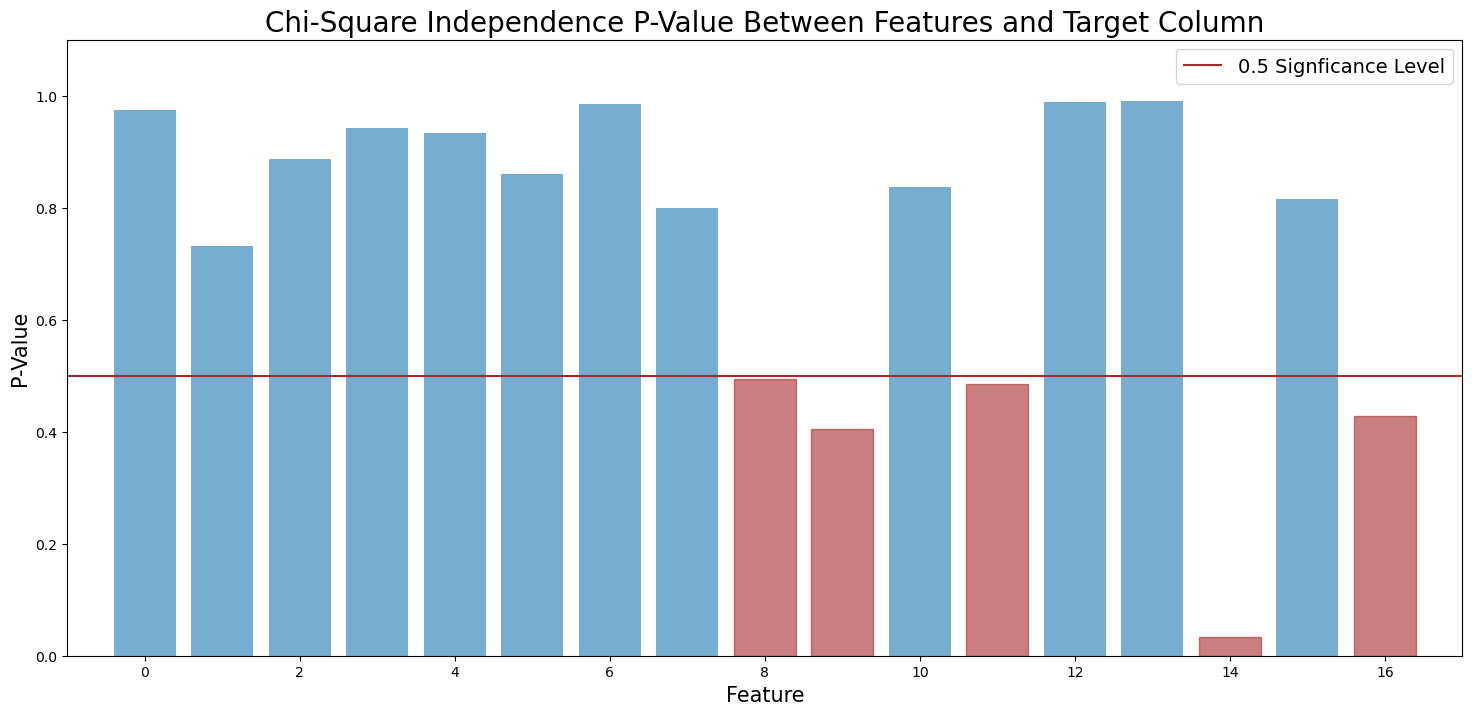

In [140]:
#Plot our results into a bar chart with a horizontal line at our chosen significance value.
plt.figure(figsize=(18, 8))
x = plt.bar(chi2_df.index, height = chi2_df["chi_values"], alpha = 0.6)
plt.hlines(0.50, xmin=-2, xmax = 17, colors="brown", label = "0.5 Signficance Level")

# Set the axis minimum and maximums
plt.axis([-1, 17, 0, 1.1])

#Find the indexes of the columns with p-value below 0.5
sig_index = list(chi2_df[chi2_df["chi_values"] < 0.5].index)

#Change the bar color of the features that have whose chi-square independence p-value is below 0.5
for idx in sig_index:
    x[idx].set_color("brown")
    
plt.xlabel("Feature", fontsize = 15)
plt.ylabel("P-Value", fontsize = 15)
plt.title("Chi-Square Independence P-Value Between Features and Target Column", fontsize=20)
plt.legend(fontsize = 14, loc = 1)
plt.show()

## Data Preparation <a name="prep"></a>

### Feature Selection

We visualized the correlation and the dependence of the numerical and categorical features with both themselves and with the target variable. We can now use what we learned to select what features will make their way into our model.

Numerical features with correlation coefficients below 0.1 will be removed from the dataset as will categorical features with a chi2 independence p-value above 0.5. There were no features that had strong correlations with each other so we will not be removing any features because of redundancy. We will leave the absence values in the dataset because we will be combining them later into one column after which we will re-calculate the correlation with our `G3` target.

In [141]:
# List of correlations with target value
tgt_corr = corr_df["Final_Grade"]

tgt_corr = tgt_corr.drop(['absences_term1',
       'absences_term2', 'absences_final', 'Term1_Grade', 'Term2_Grade',
       'Final_Grade'])

#Slice the tgt_corr list to get the features that we will drop. Leaving out the absence columns.
num_drop_list = list(tgt_corr[abs(tgt_corr) < 0.1].index)

In [142]:
# Drop all of the needed numerical features
final_data = final_data.drop(num_drop_list, axis = 1)

In [143]:
#Get all of the categorical features that were independent of the target variable and drop them.
cat_drop_list = list(chi2_df[chi2_df["chi_values"] > 0.50]["index"])
final_data = final_data.drop(cat_drop_list, axis = 1)

In [144]:
#Shape of final data. Data has only 16 columns compared to 35 before
print("Before:", final_data_numeric.shape)
print("After:", final_data.shape)

Before: (395, 35)
After: (395, 17)


In [145]:
#Data set after dropping features
final_data.head(5)

,age,Medu,Fedu,guardian,traveltime,failures,schoolsup,paid,higher,romantic,goout,absences_term1,absences_term2,absences_final,Term1_Grade,Term2_Grade,Final_Grade
0,18.0,4,4,mother,2,0,yes,no,yes,no,4,1.0,1.0,4.0,5,6,Fail
1,17.0,1,1,father,1,0,no,no,yes,no,3,NaN,NaN,NaN,5,5,Fail
2,15.0,1,1,mother,1,3,yes,yes,yes,no,2,1.0,1.0,8.0,7,8,Pass
3,15.0,4,2,mother,1,0,no,yes,yes,yes,2,0.0,0.0,2.0,15,14,Pass
4,NaN,3,3,father,1,0,no,yes,yes,no,2,0.0,0.0,4.0,6,10,Pass


### Custom Transformer

We will now combine the absence columns and create two different datasets: one that contains the `G1` and `G2` columns and one without.

We can do this with a custom transformer class that will be able to drop the first two terms of the school year as well as combining the absence values into one column. We will use this transformer to create two different datasets. One with the `G1` and `G2` columns and one without. Predicting the final term grade without the previous two terms will allow needy students to be identified at the beginning of the school year instead of after two terms. Getting resources to students much earlier will make supplemental education efforts much more effective.

In [152]:
class absences_transformer(BaseEstimator, TransformerMixin):
    
    #Initialize with only the drop_terms value that defaults to false.
    def __init__(self, drop_terms = False):
        self.drop_terms = drop_terms
        
    #Do nothing in fit. just return itself.
    def fit(self, X, y = None): 
        return self  
           
    # Sum the absence columns and then drop the first two term columns if drop_terms = True
    def transform(self, X):
        X_copy = X.copy()
        X_copy["absences_total"] = X_copy["absences_term1"] + X_copy["absences_term2"] + X_copy["absences_final"]
        X_copy = X_copy.drop(["absences_term1", "absences_term2", "absences_final"], axis = 1)
        
        if self.drop_terms:
            
            X_copy = X_copy.drop(["Term1_Grade", "Term2_Grade"], axis = 1)
            
        #Reinded the columns in the list by putting G3 at the end no matter the input
        col_list = list(X_copy.columns.drop("Final_Grade"))
        col_list.append("Final_Grade")
        X_copy = X_copy[col_list]
        
        return X_copy

In [153]:
# Use the transformer to create a dataset without the G1 and G2 columns. Initialize then fit_transform
abs_transform = absences_transformer(drop_terms=True)
final_data_dropped = abs_transform.fit_transform(final_data)

# Create a dataset with the Term1 and Term2 columns
abs_transform_G12 = absences_transformer(drop_terms=False)
final_data_G12 = abs_transform_G12.fit_transform(final_data)

In [158]:
final_data_dropped

,age,Medu,Fedu,guardian,traveltime,failures,schoolsup,paid,higher,romantic,goout,absences_total,Final_Grade
0,18.0,4,4,mother,2,0,yes,no,yes,no,4,6.0,Fail
1,17.0,1,1,father,1,0,no,no,yes,no,3,NaN,Fail
2,15.0,1,1,mother,1,3,yes,yes,yes,no,2,10.0,Pass
3,15.0,4,2,mother,1,0,no,yes,yes,yes,2,2.0,Pass
4,NaN,3,3,father,1,0,no,yes,yes,no,2,4.0,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20.0,2,2,other,1,2,no,yes,yes,no,4,11.0,Fail
391,17.0,3,1,mother,2,0,no,no,yes,no,5,3.0,Pass
392,21.0,1,1,other,1,3,no,no,yes,no,3,3.0,Fail
393,18.0,3,2,mother,3,0,no,no,yes,no,1,NaN,Pass


### Shape Of Transformed Data

In [157]:
print("Shape of data without G1 and G2:", final_data_dropped.shape)
print("Shape with G1 and G2 retained:", final_data_G12.shape)

Shape of data without G1 and G2: (395, 13)
Shape with G1 and G2 retained: (395, 15)


### Splitting Into Training and Testing Datasets

Our dataset still contains missing values and our features have yet to be scaled properly or encoded properly. Doing these things will require us to fit different transformers on our data. We have to be careful not to fit them on the data that we intend to train our model with. Because of this, the next step in our project must be to split our dataset into training and testing sections. Twenty percent of the data set will be allotted to the test dataset and eighty percent to the training data.

In [159]:
target = final_data_dropped["Final_Grade"]
x_train, x_test, y_train, y_test = train_test_split(final_data_dropped.drop("Final_Grade", axis = 1), target, test_size=0.2, random_state = 34)
x_train12, x_test12, y_train12, y_test12 = train_test_split(final_data_G12.drop("Final_Grade", axis = 1), target, test_size=0.2, random_state = 34)

In [160]:
print("Rows in original dataset:", len(final_data_dropped))
print("Rows in training data:", len(x_train))
print("Rows in test data:", len(x_test))

Rows in original dataset: 395
Rows in training data: 316
Rows in test data: 79


### Feature Scaling and Encoding Both Training and Testing Datasets

Next, we one-hot encode all of the categorical variables with the get_dummies function and scale our numerical features using a standard scaler. 

These steps will enable us to accurately train distance-dependent predictive models on our dataset. Distance can not be calculated between categorical variables so they have to be represented numerically. Additionally, numerical features often have differing scales. For example, our age column has a scale of (16-22) while our encoded features will only have values of 0-1. Features with larger scales can skew results from models with that fit training data using distance metrics and create predictions that do not represent the underlying data.

Let's take a look at the data after encoding the categorical variables. As you can see all of the categorical variables are now represented as 1 and 0 and all features have similar scales not accounting for potential outliers. 

In [161]:
def one_hot(x_train, x_test):
    
    #Select only the categorical variables from that dataframe
    cat_col = list(x_train.select_dtypes(include = ["object", "category"]).columns)
    train_cat = x_train[cat_col].copy()
    test_cat = x_test[cat_col].copy()
    
    # Create dummy variables for both the training and the testing data set
    dum_train = pd.get_dummies(train_cat, drop_first = True)
    dum_test = pd.get_dummies(test_cat, drop_first = True)
    
    # Concatenate the new categorical variables back onto the traning and testing datasets
    x_train = pd.concat([dum_train, x_train.drop(cat_col, axis = 1)], axis = 1)
    x_test = pd.concat([dum_test, x_test.drop(cat_col, axis = 1)], axis = 1)

    return x_train, x_test

In [162]:
def standard_scale(x_train, x_test, y_train, y_test):
    
    #Select only the categorical variables from that dataframe
    num_col = list(x_train.select_dtypes(exclude= ["object", "category"]).columns)
    train_num = x_train[num_col].copy()
    test_num = x_test[num_col].copy()

    #Initialize a Standard Scaler and fit it to our data
    standard = StandardScaler()
    train_num = pd.DataFrame(standard.fit_transform(train_num), index = y_train.index, columns = num_col)
    test_num = pd.DataFrame(standard.transform(test_num), index=y_test.index, columns = num_col)
    
    x_train = pd.concat([train_num, x_train.drop(num_col, axis = 1)], axis = 1)
    x_test = pd.concat([test_num, x_test.drop(num_col, axis = 1)], axis = 1)
    
    return x_train, x_test

In [163]:
#Pass out training and test datatsets to our custom encoding and scaling functions.
x_train, x_test = standard_scale(x_train, x_test, y_train, y_test)
x_train, x_test = one_hot(x_train, x_test)
x_train12, x_test12 = standard_scale(x_train12, x_test12, y_train12, y_test12)
x_train12, x_test12 = one_hot(x_train12, x_test12)

#### Transformed Training Dataset

In [164]:
# See the range of our transformed Training Data
x_train.describe().loc[["mean", "max"], :]

,guardian_mother,guardian_other,schoolsup_yes,paid_yes,higher_yes,romantic_yes,age,Medu,Fedu,traveltime,failures,goout,absences_total
mean,0.693038,0.066456,0.132911,0.46519,0.949367,0.313291,4.818223e-16,-1.180490e-16,-1.953430e-16,-5.340313e-17,-3.653899e-17,8.994212e-17,5.824121e-18
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,4.190252e+00,1.131335e+00,1.346510e+00,3.833650e+00,3.586260e+00,1.706255e+00,8.283372e+00


#### Transformed Testing Dataset

In [165]:
x_test.describe().loc[["mean", "max"], :]

,guardian_mother,guardian_other,schoolsup_yes,paid_yes,higher_yes,romantic_yes,age,Medu,Fedu,traveltime,failures,goout,absences_total
mean,0.683544,0.139241,0.113924,0.43038,0.949367,0.417722,0.141929,-0.090158,-0.075778,0.202266,-0.008518,0.173423,-0.069762
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.834679,1.131335,1.346510,3.833650,3.586260,1.706255,3.855660


### Filling Missing Values

Below we will reference our original dataset before we encoded our features and combined our absence columns. We can see that two columns have missing values. The `age` column has 12 instances where data is missing and each of the `absences` columns have 14 missing values. By slicing the dataframe where both of the columns have a value missing we can see that none of these instances overlap. In other words, no instance has missing values in both the `age` and the `absences` columns. However, when data is missing from one absence column it is missing from them all. Both of these columns were left in our data.

Now that we know that data is always missing from all absence columns we no longer need to reference our original dataset when filling in missing values.

In [166]:
#Sum the resulting boolean output of the isna() function to get the number of missing values
pd.DataFrame(final_data.isna().sum()).T

,age,Medu,Fedu,guardian,traveltime,failures,schoolsup,paid,higher,romantic,goout,absences_term1,absences_term2,absences_final,Term1_Grade,Term2_Grade,Final_Grade
0,12,0,0,0,0,0,0,0,0,0,0,14,14,14,0,0,0


In [168]:
# Look at the portion of the dataset that has data missing from the absence columns
final_data[(final_data["absences_term1"].isna()) | (final_data["absences_term2"].isna()) | (final_data["absences_final"].isna())]

,age,Medu,Fedu,guardian,traveltime,failures,schoolsup,paid,higher,romantic,goout,absences_term1,absences_term2,absences_final,Term1_Grade,Term2_Grade,Final_Grade
1,17.0,1,1,father,1,0,no,no,yes,no,3,NaN,NaN,NaN,5,5,Fail
6,16.0,2,2,mother,1,0,no,no,yes,no,4,NaN,NaN,NaN,12,12,Pass
18,17.0,3,2,mother,1,3,no,no,yes,no,5,NaN,NaN,NaN,6,5,Fail
64,15.0,4,3,father,1,0,yes,no,yes,yes,4,NaN,NaN,NaN,10,10,Pass
106,15.0,2,2,mother,1,0,yes,yes,yes,no,2,NaN,NaN,NaN,7,8,Fail
163,17.0,1,3,father,1,0,no,no,no,no,3,NaN,NaN,NaN,10,10,Pass
216,17.0,4,3,mother,1,2,no,yes,yes,yes,5,NaN,NaN,NaN,6,6,Fail
217,18.0,3,3,father,1,1,no,yes,yes,no,4,NaN,NaN,NaN,6,6,Fail
251,16.0,3,3,other,3,0,yes,no,yes,no,3,NaN,NaN,NaN,7,10,Pass
288,18.0,2,1,mother,1,0,no,yes,yes,no,4,NaN,NaN,NaN,15,14,Pass


In [169]:
# Look at the portion of the dataset that has data missing from the age column
final_data_dropped[(final_data_dropped["age"].isna())]

,age,Medu,Fedu,guardian,traveltime,failures,schoolsup,paid,higher,romantic,goout,absences_total,Final_Grade
4,NaN,3,3,father,1,0,no,yes,yes,no,2,4.0,Pass
26,NaN,2,2,mother,1,0,no,yes,yes,no,2,2.0,Pass
29,NaN,4,4,mother,1,0,no,yes,yes,yes,5,16.0,Pass
55,NaN,2,1,mother,1,0,no,yes,yes,yes,4,8.0,Pass
59,NaN,4,2,mother,1,0,no,no,yes,no,3,2.0,Pass
95,NaN,1,1,mother,2,1,yes,yes,yes,no,2,2.0,Pass
123,NaN,4,4,mother,1,0,no,no,yes,no,4,18.0,Pass
128,NaN,2,2,mother,1,2,no,no,yes,no,3,0.0,Fail
189,NaN,1,2,mother,1,0,no,no,yes,no,3,4.0,Pass
269,NaN,2,1,mother,2,0,no,no,no,yes,5,0.0,Fail


From these small samples, it does not seem that the missing data has any apparent patterns or carries any significance. We should be clear to fill the data with other values if we choose to. We will leave the missing values in the original data and only fill missing values in our previously split training and testing datasets to preserve the reference data.

We will first compare three different imputing methods for the `age` column and then evaluate the values in the `absences_total` column using the same methods. 
- <i>Median</i>: Fill the missing age values with the median of their column.
- <i>Mean</i>: Fill the missing age values with the median of their column.
- <i>K-Nearest Neighbors</i>: Fill in the missing age values by grouping every data point by all features in the dataset. Then setting the age values equal to the age mean of the most similar data points

In [175]:
#Calculate what the age column would be if we were to fill its missing values with the median or the mean
mean_age = x_train["age"].fillna(x_train["age"].mean())
median_age = x_train["age"].fillna(x_train["age"].median())

#Use the KNN imputer to see what the age values would be when they are imputed with KNN algorithm excluding the target_value
knn = KNNImputer(n_neighbors = 5)
final_data_knn = knn.fit_transform(x_train)
knn_age = pd.DataFrame(final_data_knn, columns = x_train.columns)["age"]

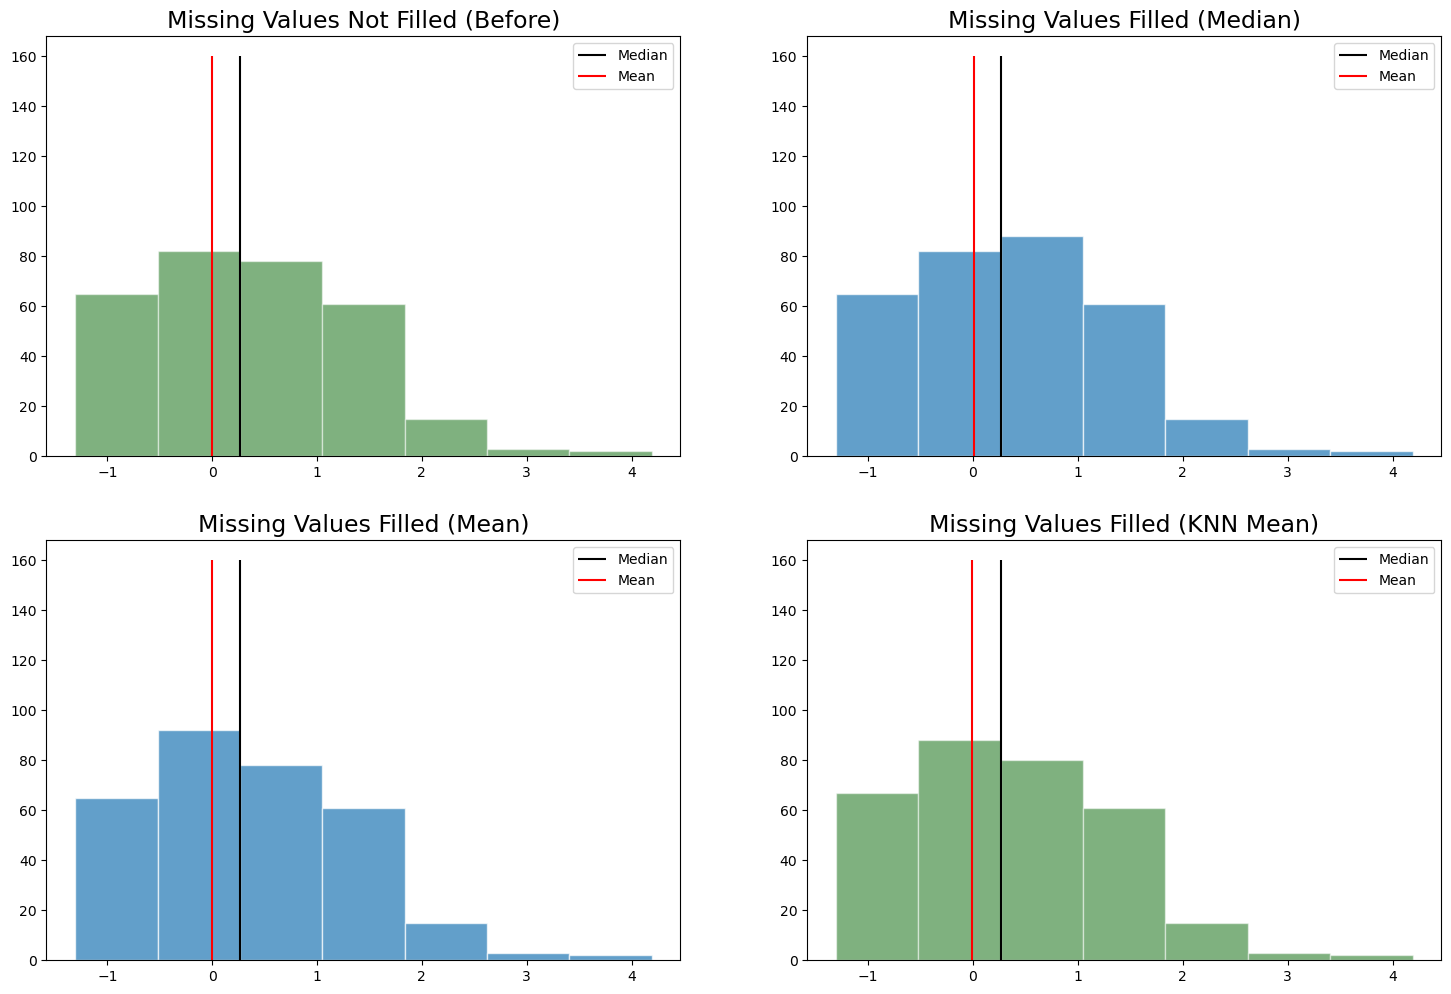

In [176]:
# Plotting the distribution of age values with histograms. Placing lines at both the median and mean positions.
# Comparing how the age distribution would change with simple imputation using mean and median values.

fig = plt.figure(figsize=[18, 12])

fig.add_subplot(2, 2, 1)
plt.hist(x_train["age"], ec="white", alpha=0.5, bins = 7, color="darkgreen")
plt.vlines(x_train["age"].median(), ymin=0, ymax=160, colors="black", label = "Median")
plt.vlines(x_train["age"].mean(), ymin=0, ymax=160, colors="red", label="Mean")
plt.title("Missing Values Not Filled (Before)", fontsize = 17)
plt.legend()

fig.add_subplot(2, 2, 2)
plt.hist(median_age, ec="white", alpha=0.7, bins = 7)
plt.vlines(median_age.median(), ymin=0, ymax=160, colors="black", label = "Median")
plt.vlines(median_age.mean(), ymin=0, ymax=160, colors="red", label="Mean")
plt.title("Missing Values Filled (Median)", fontsize=17)
plt.legend()

fig.add_subplot(2, 2, 3)
plt.hist(mean_age, ec="white", alpha=0.7, bins = 7)
plt.vlines(mean_age.median(), ymin=0, ymax=160, colors="black", label = "Median")
plt.vlines(mean_age.mean(), ymin=0, ymax=160, colors="red", label="Mean")
plt.title("Missing Values Filled (Mean)", fontsize=17)
plt.legend()

fig.add_subplot(2, 2, 4)
plt.hist(knn_age, ec="white", alpha=0.5, bins = 7, color="darkgreen")
plt.vlines(knn_age.median(), ymin=0, ymax=160, colors="black", label = "Median")
plt.vlines(knn_age.mean(), ymin=0, ymax=160, colors="red", label="Mean")
plt.title("Missing Values Filled (KNN Mean)", fontsize=17)
plt.legend()

plt.show()

Looking at the distribution of the age value before and after filling in the missing values can tell us if our imputation method may corrupt the makeup of our dataset. It is important that we don't change the underlying distribution of any of our variables when filling in missing values. For both the <i>mean</i> and <i>median</i> methods we can see that the distribution shifts significantly with the mode changing for the median fill technique. The KNN imputer both preserves the underlying distribution and uses grouping methods to give us a more realistic imputation. We will use the KNN imputer to fill in the missing values in the age and the absence total columns below for both our training and testing datasets.

In [177]:
#Use the KNN imputer to get the age values for both training datasets

#Initialize the KNN imputers
knn = KNNImputer(n_neighbors = 5)
knn12 = KNNImputer(n_neighbors = 5)

#Fit transform on the training data
knn_train = knn.fit_transform(x_train)
knn_train12 = knn12.fit_transform(x_train12)
knn_test = knn.transform(x_test)
knn_test12 = knn12.transform(x_test12)

#Set the training datasets equal to the output from the imputer
x_train = pd.DataFrame(knn_train, columns = x_train.columns, index = x_train.index)
x_train12 = pd.DataFrame(knn_train12, columns = x_train12.columns, index = x_train12.index)

#Set the testing datasets equal to the output from imputation
x_test = pd.DataFrame(knn_test, columns = x_test.columns, index = x_test.index)
x_test12 = pd.DataFrame(knn_test12, columns = x_test12.columns, index = x_test12.index)

As you can see below we have filled all of the missing values in the `age` and `absence_total` columns in each of our training and testing datasets. At this point all of our data preparation is complete. We will not move on to the nxt phase of our project, training and evaluating potential models.

In [178]:
#We have gotten rid of all of the missing values in the age and absences_total columns
pd.DataFrame([x_train.isna().sum(), x_test.isna().sum(), x_train12.isna().sum(), x_test12.isna().sum()], 
             index = ["X_Train", "X_Test", "X_Train12", "X_Test12"])

,guardian_mother,guardian_other,schoolsup_yes,paid_yes,higher_yes,romantic_yes,age,Medu,Fedu,traveltime,failures,goout,absences_total,Term1_Grade,Term2_Grade
X_Train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
X_Test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
X_Train12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X_Test12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Selection and Evaluation <a name="model_selection"></a>

### Fitting Promising Models

We have thoroughly explored and prepared our data. It is now time to train and choose a model. We had previously decided that we would leverage classification techniques to predict final-term grades. As we can see below we transformed our target value into "Pass" and "Fail" values. 

We will evaluate our models by comparing their cross-validated accuracy score (the rate at which they make the correct predictions). After choosing a model our model prediction threshold will be adjusted to capture a higher percentage of struggling students.

We will consider the four different classification models:

- <u>Logistic Regression</u>: A supervised algorithm usually used for binary classification tasks.
<br>
- <u>Random Forest Classifier</u>: An ensemble of decision tree classifiers that averages the decisions of all predictions to create a final target value prediction.
<br>

- <u>Neural Network (MLP Classifier)</u>: A machine learning technique that creates a connected network of nodes and weights that are adjusted to create accurate predictions. Can support both regression and classification tasks.
<br>

- <u>Support Vector Machine Classifier</u>: A classification method that attempts to separate data classes using a hyperplane. Single models are only used for binary classification. Multi-class predictions utilize a collection of SVM models.

In [179]:
y_train.value_counts()

Pass    212
Fail    104
Name: Final_Grade, dtype: int64

In [180]:
# Initialize a dataframe to store the accuracy of our models.
cross_val_df = pd.DataFrame(columns = ["Cross_Val", "Cross_Val12"], 
                            index = ["Logistic", "Random_Forest", "Neural_Network", "SVC"])

#### Logistic Regression

In [181]:
#Initialize logistic regression models 
log = LogisticRegression()
log12 = LogisticRegression()

# Fit our models on both the G1 and G2 inclusive and excluisve datasets
log.fit(x_train, y_train)
log12.fit(x_train12, y_train12)

#Set our respective indexes in our daatframe equal to the average accuracy score over 3 cross-validation folds.
cross_val_df.loc["Logistic", "Cross_Val"] = np.average(cross_val_score(log, x_train, y_train, cv=3, scoring="accuracy"))
cross_val_df.loc["Logistic", "Cross_Val12"] = np.average(cross_val_score(log12, x_train12, y_train12, cv=3, scoring="accuracy")) 

#### Random Forest

In [182]:
#Initialize random forest classification models 
forest = RandomForestClassifier()
forest12 = RandomForestClassifier()

# Fit our models on both the G1 and G2 inclusive and excluisve datasets
forest.fit(x_train, y_train)
forest12.fit(x_train12, y_train12)

#Set our respective indexes in our daatframe equal to the average accuracy score over 3 cross-validation folds.
cross_val_df.loc["Random_Forest", "Cross_Val"] = np.average(cross_val_score(forest, x_train, y_train, cv=3, scoring="accuracy"))
cross_val_df.loc["Random_Forest", "Cross_Val12"] = np.average(cross_val_score(forest12, x_train12, y_train12, cv=3, scoring="accuracy"))

#### MLPClassifier

In [183]:
warnings.filterwarnings('ignore')

#Initialize neural networks (MLP Classifier) 
nn = MLPClassifier()
nn_12 = MLPClassifier()

# Fit our models on both the G1 and G2 inclusive and excluisve datasets
nn.fit(x_train, y_train)
nn_12.fit(x_train12, y_train12)

#Set our respective indexes in our daatframe equal to the average accuracy score over 3 cross-validation folds.
cross_val_df.loc["Neural_Network", "Cross_Val"] = np.average(cross_val_score(nn, x_train, y_train, cv=3, scoring="accuracy"))
cross_val_df.loc["Neural_Network", "Cross_Val12"] = np.average(cross_val_score(nn_12, x_train12, y_train12, cv=3, scoring="accuracy"))

#### SVC Classifier

In [184]:
#Initialize support vectore machine models 
svc = SVC()
svc12 = SVC()

# Fit our models on both the G1 and G2 inclusive and excluisve datasets
svc.fit(x_train, y_train)
svc12.fit(x_train12, y_train12)

#Set our respective indexes in our daatframe equal to the average accuracy score over 3 cross-validation folds.
cross_val_df.loc["SVC", "Cross_Val"] = np.average(cross_val_score(svc, x_train, y_train, cv=3, scoring="accuracy"))
cross_val_df.loc["SVC", "Cross_Val12"] = np.average(cross_val_score(svc12, x_train12, y_train12, cv=3, scoring="accuracy"))

### Comparing Our Models

All four of our models performed fairly similarly judging by their accuracy scores alone. Our random forest classifier performed slightly better for both the `Term1_Grade` and `Term2_Grade` exclusive and inclusive datasets. We know that random forest models have a large number of hyperparameters that can be tuned to increase our accuracy. Because it performed slightly better for both datasets and there is a large potential for hyperparameter tuning we will continue with our Random Forest Classifier.

In [186]:
#Output the accuracy scores for all of our models
print(cross_val_df)

               Cross_Val Cross_Val12
Logistic        0.721563    0.882959
Random_Forest    0.67086    0.898772
Neural_Network  0.702546    0.892513
SVC             0.699371    0.879844


## Fine Tuning The Model <a name="final_model"></a>

### Using Grid Search

We can tune the parameters of our random forest model to change the constraints under which it is trained. These parameter values are known as hyperparameters and we can utilize a GridSearch that trains a model with each combination of hyperparameters passed. While this process can be computationally expensive it can provide valuable model improvements but it is not guaranteed to deliver improvements.


In [187]:
#Re-initialize our model type of choice. Random Forest Classifiers
forest = RandomForestClassifier()
forest12 = RandomForestClassifier()

# Create a dictionary of hyperparameters. Each combination will be tested in out GridSearch
params_forest = {'bootstrap': [True, False], 
                'min_samples_split': [1, 2, 5],
                'min_samples_leaf': [4, 6, 8, 11],
                'n_estimators': [20, 40, 60, 80, 100] }

#Initialzie our GridSearch classes with out parameter grid
grid_forest = GridSearchCV(forest, param_grid=params_forest, cv= 3, verbose = 1)
grid_forest12 = GridSearchCV(forest12, param_grid=params_forest, cv= 3, verbose = 1)

#Fit these GridSearch classes
grid_forest.fit(x_train, y_train)
grid_forest12.fit(x_train12, y_train12)

#Choose the model with the most successful combination of hyperparameters
best_forest = grid_forest.best_estimator_
best_forest12 = grid_forest12.best_estimator_

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [188]:
# Print the best parameters for both Random Forest models after GridSearch
print("Forest Params:", grid_forest.best_params_)
print("Forest (G1 + G2) Params:", grid_forest12.best_params_)

Forest Params: {'bootstrap': False, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 80}
Forest (G1 + G2) Params: {'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 40}


In [189]:
# Set the respective indexes in the cross_val dataframe equal to the average of a cross_val_score
cross_val_df.loc["Random_Forest_Tuned", "Cross_Val"] = np.average(cross_val_score(best_forest, x_train, y_train, cv=3, scoring="accuracy"))
cross_val_df.loc["Random_Forest_Tuned", "Cross_Val12"] = np.average(cross_val_score(best_forest12, x_train12, y_train12, cv=3, scoring="accuracy"))

In [190]:
#Output the accuracy scores for all of our models and our tuned model
print(cross_val_df)

                    Cross_Val Cross_Val12
Logistic             0.721563    0.882959
Random_Forest         0.67086    0.898772
Neural_Network       0.702546    0.892513
SVC                  0.699371    0.879844
Random_Forest_Tuned  0.677329    0.901827


The GridSearch marginally improved our Random Forest model's accuracy scores. We originally chose a classification-based approach because we would be able to increase the model bias toward capturing failing students. To do this we will change the threshold value to try to increase our recall score. There is always a tradeoff between recall and precision so we have to choose a threshold value that balances the two scores.

In [191]:
#Predict the probabilities of the "Fail" class
y_pred = best_forest.predict_proba(x_train)[:, 0]
y_pred12 = best_forest12.predict_proba(x_train12)[:, 0]

In [192]:
#Calculate the precisions and recall scores for each threshold value
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred, pos_label="Fail")
precisions12, recalls12, thresholds12 = precision_recall_curve(y_train12, y_pred12, pos_label="Fail") 

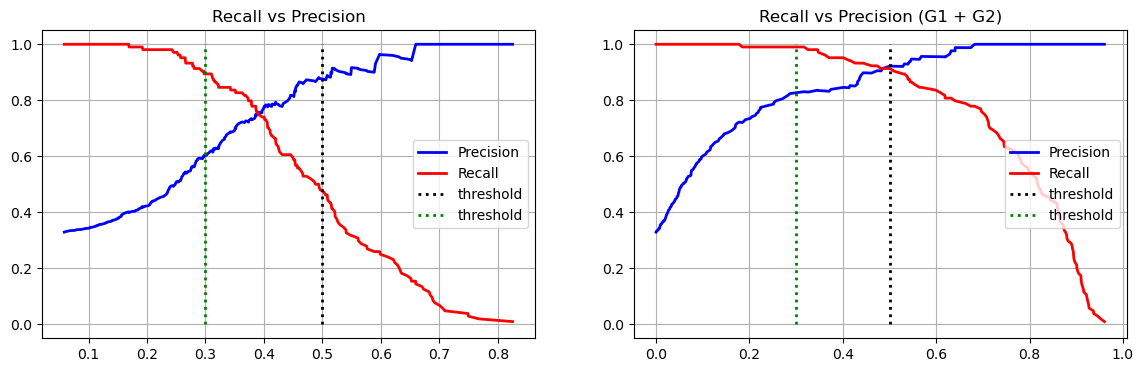

In [193]:
#The current threshold value
threshold = 0.5

fig = plt.figure(figsize=(14, 4))  # extra code – it's not needed, just formatting

fig.add_subplot(1, 2, 1)
#Plot the precision and recall lines vs the threshold value
plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "r-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold", linewidth = 2)
plt.vlines(0.3, 0, 1.0, "g", "dotted",  label="threshold", linewidth = 2)
plt.legend(loc="center right")
plt.title("Recall vs Precision")
plt.grid()

fig.add_subplot(1, 2, 2)
#Plot the precision and recall lines vs the threshold value
plt.plot(thresholds12, precisions12[:-1], "b-", label="Precision", linewidth=2)
plt.plot(thresholds12, recalls12[:-1], "r-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold", linewidth = 2)
plt.vlines(0.3, 0, 1.0, "g", "dotted",  label="threshold", linewidth = 2)
plt.legend(loc="center right")
plt.title("Recall vs Precision (G1 + G2)")
plt.grid()

plt.show()

0.2 looks like a good place to set our threshold. Below 0.2 the slope for the recall lines flatten out meaning that decreasing it further will not give us a large increase in recall. 

In [194]:
# Get the index of the first threshold value that is larger then our chosen threshold
idx = (thresholds > 0.2).argmax()
idx12 = (thresholds12 > 0.2).argmax()

#Print the precision and recall for the threshold that we have chosen
print("Precision:", precisions[idx])
print("Recall:", recalls[idx], "\n")

print("Precision (G1 + G2):", precisions12[idx])
print('Recall (G1 + G2):', recalls12[idx])

Precision: 0.42323651452282157
Recall: 0.9807692307692307 

Precision (G1 + G2): 0.4388185654008439
Recall (G1 + G2): 1.0


### Measuring Performance on Test Set

In [195]:
# Predict the test datasets using our tuned models
y_test_pred = best_forest.predict_proba(x_test)
y_test_pred12 = best_forest12.predict_proba(x_test12)

In [196]:
#Set the threshold
threshold = 0.2

#Assing a Fail or Pass value based on the proababilites output by our model
y_test_pred = ["Fail" if x > threshold else "Pass" for x, y in y_test_pred]
y_test_pred12 = ["Fail" if x > threshold else "Pass" for x, y in y_test_pred12]

In [197]:
#Print the Recall, Precision, and Accuracy scores for each model and each dataset

print("Recall Score:", recall_score(y_test, y_test_pred, pos_label="Fail"))
print("Recall Score (G1 and G2):", recall_score(y_test12, y_test_pred12, pos_label="Fail"), "\n")

print("Precision Score:", precision_score(y_test, y_test_pred, pos_label="Fail"))
print("Precision Score (G1 and G2):", precision_score(y_test12, y_test_pred12, pos_label="Fail"), "\n")

print("Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Accuracy Score (G1 and G2):", accuracy_score(y_test12, y_test_pred12))

Recall Score: 0.8461538461538461
Recall Score (G1 and G2): 1.0 

Precision Score: 0.34375
Precision Score (G1 and G2): 0.7428571428571429 

Accuracy Score: 0.4177215189873418
Accuracy Score (G1 and G2): 0.8860759493670886


## Presenting Our Solution <a name="conclusion"></a>

### Overview

In this project we imported data from two Portuguese schools that measured their student's grades over three school terms. We then used explored the data provided and transformed the data to be suitable to run through our predictive models. We compared four different models and eventually settled on a Random Forest model. We tuned this model to introduce a bias to select for students that are prone to struggling then we evaluated that model on the testing dataset  

### Conclusion

The purpose of this project was to identify struggling students in order to provide them with the learning resources needed need to pass their classes. This project utilized predictive analytics and a variety of data exploration techniques to describe the relationship between student performance variables and final-term grades.

This project analyzed two different training datasets that offer vastly different utilities in their ability to identify failing students. Our `G1` and `G2` inclusive dataset would force school administration to wait to identify students until the final school term. We don't believe that this offers close to the utility that identifying these same students at the beginning of the term. Once the first two terms are finished it could be much more challenging to bring a student's grades back into the passing range. Even though the accuracy and recall of our term-exclusive datasets are lower overall the additional utility they provide by predicting student grades at the beginning of the school year outweighs any decrease in accuracy and recall.

Because of our measured accuracy and recall values our recommendation is that school administration uses the `G1` and `G2` exclusive model to allot additional learning resources. Also due to our lower precision rate from maximizing our recall, we recommend putting a system in place that allows misclassified successful students the ability to prove themselves and graduate from the additional learning system. As a result of administration feedback, we can further tune the model to increase the accuracy depending on what classification bias is preferred.

#### Future Research

Although successful there are several facets of this project that could improve for future research. 

- <u>Dataset Size:</u> While substantial for a small project, only contained a mere 395 instances. Training a model on such a small dataset can lead to overfitting and we can't make any claims as to if this dataset is representative of the whole Portuguese school system and that our model will generalize to larger student populations. More extensive data collection would allow for more representative research and allow our research team and our customer to be more confident in the project results.
- <u> Model Tuning:</u> Attempting model tuning with grid search did not result in a large improvement in model performance. Further research into additional tuning techniques would result in a more effective tuning process.
- <u> Additional Predictive Techniques:</u> Only classification techniques were evaluated during this project. The addition of regression techniques and multi-class classification would be a great starting point for additional research.